In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PEPit import PEP as PEPit
from GPEP import GPEP

In [2]:
def wc_gradient_descent(L, mu, gamma, n, wrapper="cvxpy", solver=None, verbose=1):
    from PEPit.functions import SmoothStronglyConvexFunction
    
    # Instantiate PEP
    problem = PEPit()

    # Declare a smooth convex function
    func = problem.declare_function(SmoothStronglyConvexFunction, L=L, mu=mu)

    # Then define the starting point x0 of the algorithm
    x0 = problem.set_initial_point()
    y0 = problem.set_initial_point()

    # Set the initial constraint that is the distance between x0 and x^*
    problem.set_initial_condition((x0 - y0) ** 2 <= 1)

    # Run n steps of the GD method
    x = x0
    y = y0
    for _ in range(n):
        x = x - gamma * func.gradient(x)
        y = y - gamma * func.gradient(y)

    # Set the performance metric to the function values accuracy
    problem.set_performance_metric((x - y) ** 2)

    # Solve the PEP
    pepit_verbose = max(verbose, 0)
    pepit_tau = problem.solve(wrapper=wrapper, solver=solver, verbose=pepit_verbose)

    return pepit_tau

In [ ]:
def cma_gradient_descent(L, mu, gamma, n, verbose=1):
  from GPEP.functions import SmoothStronglyConvexFunction
  
  f = SmoothStronglyConvexFunction(L=L, mu=mu)
  x0 = f.gen_initial_point()
  y0 = f.gen_initial_point()

  pep = GPEP(f)
  pep.set_initial_condition((x0 - y0).norm() ** 2 <= 1)
  
  x = x0
  y = y0
  for _ in range(n):
    x = x - gamma * f.grad(x)
    y = y - gamma * f.grad(y)

  pep.set_metric((x - y).norm() ** 2)

  _, gpep_tau = pep.solve(verbose=verbose)
  return gpep_tau

In [ ]:
L = 1
mu = 0.1
n = 2
verbose = 1

In [7]:
gammas = np.linspace(0.1, 2, 5)
theoretical_taus = [max((1 - L * gamma) ** 2, (1 - mu * gamma) ** 2) ** n for gamma in gammas]
pepit_taus = [wc_gradient_descent(L=L, mu=mu, gamma=gamma, n=n, verbose=verbose) for gamma in gammas]
gpep_taus = [cma_gradient_descent(L=L, mu=mu, gamma=gamma, n=n, verbose=verbose) for gamma in gammas]

(PEPit) Setting up the problem: size of the Gram matrix: 6x6
(PEPit) Setting up the problem: performance measure is the minimum of 1 element(s)
(PEPit) Setting up the problem: Adding initial conditions and general constraints ...
(PEPit) Setting up the problem: initial conditions and general constraints (1 constraint(s) added)
(PEPit) Setting up the problem: interpolation conditions for 1 function(s)
			Function 1 : Adding 12 scalar constraint(s) ...
			Function 1 : 12 scalar constraint(s) added
(PEPit) Setting up the problem: additional constraints for 0 function(s)
(PEPit) Compiling SDP
(PEPit) Calling SDP solver
(PEPit) Solver status: optimal (wrapper:cvxpy, solver: SCS); optimal value: 0.960610042502014
(PEPit) Postprocessing: solver's output is not entirely feasible (smallest eigenvalue of the Gram matrix is: -5.14e-05 < 0).
 Small deviation from 0 may simply be due to numerical error. Big ones should be deeply investigated.
 In any case, from now the provided values of parameters

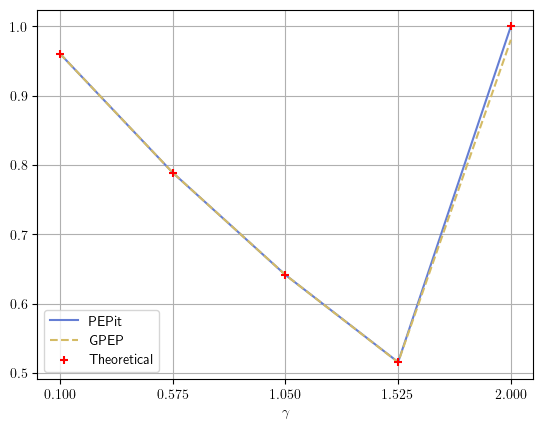

In [8]:
import matplotlib

matplotlib.rcParams["text.usetex"] = True

plt.plot(gammas, pepit_taus, color="#657ed4", label="PEPit")
plt.plot(gammas, gpep_taus, color="#d4bb65", linestyle="--", label="GPEP")
plt.scatter(gammas, theoretical_taus, marker='+', color='r', label="Theoretical", zorder=9)
plt.xlabel("$\\gamma$")
plt.xticks(gammas)
plt.grid("on")
plt.legend()
plt.savefig("gd_gpep_pepit.svg", bbox_inches="tight")